In [2]:
import math
import os
import gpxpy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.constants import R
from shapely.geometry import Point, LineString
from math import radians
import sl_rtd as sl

#__Author__: pablo-chacon
#__Version__: 1.0.0
#__Date__: 2024-05-11



In [3]:
# Function to parse GPX file and extract waypoint data
def parse_gpx(file_path):
    with open(file_path, 'r') as file:
        gpx = gpxpy.parse(file)
        points_data = []
        for track in gpx.tracks:
            for segment in track.segments:
                for point in segment.points:
                    points_data.append({'Latitude': point.latitude, 'Longitude': point.longitude, 'Time': point.time})
        return pd.DataFrame(points_data)


In [4]:
# GPX dir
gpx_dir = 'user_profiles'

# Read GPX files, parse waypoints.
dfs = []
for filename in os.listdir(gpx_dir):
    if filename.endswith('.gpx'):
        gpx_file_path = os.path.join(gpx_dir, filename)
        df = parse_gpx(gpx_file_path)
        dfs.append(df)

# Concatenate DataFrames into DataFrame
gdf = pd.concat(dfs, keys=range(1, len(dfs) + 1))

In [5]:
# Calculate the great circle distance between gps points
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    return distance

In [6]:
# Read GPX files and parse waypoints
gpx_folder = 'user_profiles'
user_profiles = []

In [7]:
for filename in os.listdir(gpx_folder):
    if filename.endswith('.gpx'):
        gpx_file_path = os.path.join(gpx_folder, filename)
        df = parse_gpx(gpx_file_path)
        user_profiles.append(df)

# Concatenate DataFrames into one
df = pd.concat(user_profiles, ignore_index=True)

In [8]:
# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

In [9]:
# Calculate distance and speed
total_distance = 0
for i in range(len(gdf) - 1):
    lat1, lon1 = gdf.iloc[i].Latitude, gdf.iloc[i].Longitude
    lat2, lon2 = gdf.iloc[i + 1].Latitude, gdf.iloc[i + 1].Longitude
    total_distance += haversine_distance(lat1, lon1, lat2, lon2)

gdf['TimeDelta'] = gdf['Time'].diff().dt.total_seconds() / 3600
gdf['Speed'] = total_distance / gdf['TimeDelta']

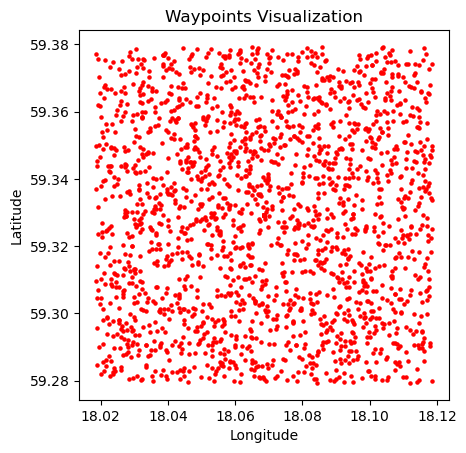

In [10]:
# Plot waypoints
gdf.plot(marker='o', color='red', markersize=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Waypoints Visualization')
plt.show()

In [11]:
pd.to_pickle(gdf, 'trajectory.pkl')

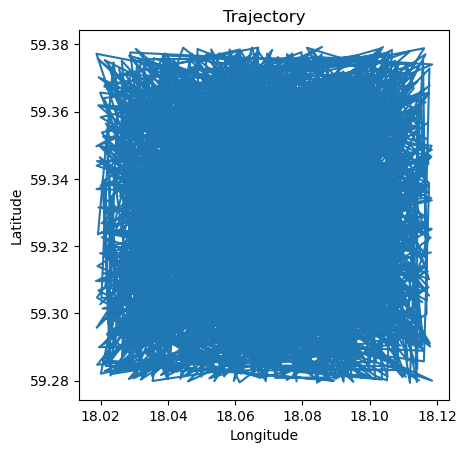

In [12]:
# Plot trajectory
trajectory = LineString(gdf['geometry'])
trajectory_gdf = gpd.GeoDataFrame(geometry=[trajectory])
trajectory_gdf.plot()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trajectory')
plt.show()

In [ ]:
import sl_rtd as sl

